In [58]:
import math
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ---------- use your existing config names ----------
CSV_PATH_user   = '/content/per_user_features_timeaware_pruned1.csv'
CSV_PATH_global = '/content/global_features_timeaware_pruned1.csv'
MIN_ROWS_FOR_SPLIT = 3
TRAIN_FRAC = 0.5
ID_COLS     = ['user','day']
LABEL_COLS  = ['is_malicious','scenario']
RULE_FLAG_NAMES   = ['wikileaks_flag','offhour_logon_flag','offhour_usb_flag','offhour_http_flag']
RULE_WEIGHTS = {"wikileaks_flag":1.0, "offhour_usb_flag":0.7, "offhour_http_flag":0.3, "offhour_logon_flag":0.3}

RANDOM_STATE = 42

# If True use per-user 0.99 percentile threshold; else global percentile
PER_USER_THRESHOLD = True
PCT_THRESHOLD = 99

# ---------- load data ----------
df_user = pd.read_csv(CSV_PATH_user, parse_dates=['day'])
df_global = pd.read_csv(CSV_PATH_global, parse_dates=['day'])

# basic checks + normalize types
for df in (df_user, df_global):
    assert all(c in df.columns for c in ID_COLS + [LABEL_COLS[0]]), "Missing required columns"
    df['user'] = df['user'].astype(str)
    df['day']  = pd.to_datetime(df['day']).dt.floor('D')
    df.drop_duplicates(subset=ID_COLS, inplace=True)

# conservative: intersect key sets if they differ (avoid mismatches)
keys_user = set(zip(df_user['user'], df_user['day']))
keys_glob = set(zip(df_global['user'], df_global['day']))
if keys_user != keys_glob:
    print("Warning: per/global key sets differ. Intersecting to common keys.")
    common = keys_user & keys_glob
    # keep only common keys
    df_user = df_user[df_user.apply(lambda r: (r['user'], r['day']) in common, axis=1)].reset_index(drop=True)
    df_global = df_global[df_global.apply(lambda r: (r['user'], r['day']) in common, axis=1)].reset_index(drop=True)
    print("After intersection:", df_user.shape, df_global.shape)

# ---------- build per-user time-respecting train/test KEY sets ----------
def per_user_time_split_keys(df, train_frac=0.5, min_rows=3):
    keys_train = []
    keys_test = []
    for u, g in df.groupby('user'):
        g = g.sort_values('day')
        n = len(g)
        if n < min_rows:
            keys_train.append(g[ID_COLS])
            continue
        i1 = int(math.floor(train_frac * n))
        i1 = max(1, min(i1, n-1))  # ensure at least 1 row in each part when possible
        keys_train.append(g.iloc[:i1][ID_COLS])
        keys_test.append(g.iloc[i1:][ID_COLS])
    keys_train = pd.concat(keys_train).reset_index(drop=True)
    keys_test  = pd.concat(keys_test).reset_index(drop=True) if keys_test else pd.DataFrame(columns=ID_COLS)
    return keys_train, keys_test

train_keys, test_keys = per_user_time_split_keys(df_user, train_frac=TRAIN_FRAC, min_rows=MIN_ROWS_FOR_SPLIT)
print("Train keys:", len(train_keys), "Test keys:", len(test_keys))

# ---------- apply keys to get full train/test rows (both files) ----------
train_df   = df_user.merge(train_keys, on=ID_COLS, how='inner')
test_df    = df_user.merge(test_keys,  on=ID_COLS, how='inner')
train_g1 = df_global.merge(train_keys, on=ID_COLS, how='inner')
test_g1  = df_global.merge(test_keys,  on=ID_COLS, how='inner')

train_ben_df = train_df[train_df['is_malicious']==0].reset_index(drop=True)
if train_ben_df.empty:
    raise ValueError("No benign rows in training partition — cannot fit IF")

print("Shapes (per-user)   train/test:", train_df.shape, test_df.shape)
print("Shapes (global)     train/test:", train_g1.shape, test_g1.shape)

# ---------- choose normalized/z-feature columns (drop raw, IDs, labels, flags) ----------
# heuristics to pick normalized features produced by your pipeline
# per-user z features typically contain '_user_z' (or '_user_z_7d' variants)
per_user_z_cols = [c for c in df_user.columns if ('_user_z' in c)]
# global z features typically contain '_global_z'
global_z_cols   = [c for c in df_global.columns if ('_global_z' in c)]

# Safety: if none found raise a clear error
if len(per_user_z_cols) == 0:
    print("Warning: no per-user z columns found - check your CSV column names.")
if len(global_z_cols) == 0:
    print("Warning: no global z columns found - check your CSV column names.")

# We will remove all ID_COLS + LABEL_COLS + RULE_FLAG_NAMES from the Xs
drop_from_X = set(ID_COLS) | set(LABEL_COLS) | set(RULE_FLAG_NAMES)

# final per-user X/y
# y should be the is_malicious label
y_per_train = train_ben_df[LABEL_COLS[0]].astype(int).reset_index(drop=True)
y_per_test  = test_df[LABEL_COLS[0]].astype(int).reset_index(drop=True)

# if any flags aren't present, filter them out
present_flags = [f for f in RULE_FLAG_NAMES if f in df_user.columns]

X_train_if = train_ben_df[per_user_z_cols].copy().reset_index(drop=True)
X_test  = test_df[per_user_z_cols].copy().reset_index(drop=True)

# ensure numeric and fill nan with 0.0 (z-scores were already normalized but may have NaNs)
X_train_if = X_train_if.apply(pd.to_numeric, errors='coerce').fillna(0.0)
X_test  = X_test.apply(pd.to_numeric, errors='coerce').fillna(0.0)

# final global X/y
y_glob_train = train_g1[LABEL_COLS[0]].astype(int).reset_index(drop=True)
y_glob_test  = test_g1[LABEL_COLS[0]].astype(int).reset_index(drop=True)

train_g = train_g1[global_z_cols].copy().reset_index(drop=True)
test_g = test_g1[global_z_cols].copy().reset_index(drop=True)

train_g = train_g.apply(pd.to_numeric, errors='coerce').fillna(0.0)
test_g = test_g.apply(pd.to_numeric, errors='coerce').fillna(0.0)

# ---------- optionally keep flags appended to X if you DO want them (comment/uncomment) ----------
# If you *do not* want flags in X (you said you want them removed) then keep flags out.
# If instead you want flags kept, uncomment the block below:
#
# X_train_if = pd.concat([X_train_if.reset_index(drop=True), train_df[present_flags].reset_index(drop=True)], axis=1)
# X_test  = pd.concat([X_test.reset_index(drop=True),  test_df[present_flags].reset_index(drop=True)], axis=1)
# train_g = pd.concat([train_g.reset_index(drop=True), train_g1[present_flags].reset_index(drop=True)], axis=1)
# test_g = pd.concat([test_g.reset_index(drop=True),  test_g1[present_flags].reset_index(drop=True)], axis=1)

# ---------- final sanity prints ----------
print("Per-user X shapes (train/test):", X_train_if.shape, X_test.shape)
print("Global   X shapes (train/test):", train_g.shape, test_g.shape)
print("Per-user label counts (train/test):", y_per_train.value_counts().to_dict(), y_per_test.value_counts().to_dict())
print("Global   label counts (train/test):", y_glob_train.value_counts().to_dict(), y_glob_test.value_counts().to_dict())


print("Saved split CSVs to current working directory.")


Train keys: 160738 Test keys: 160861
Shapes (per-user)   train/test: (160738, 59) (160861, 59)
Shapes (global)     train/test: (160738, 59) (160861, 59)
Per-user X shapes (train/test): (160738, 34) (160861, 34)
Global   X shapes (train/test): (160738, 34) (160861, 34)
Per-user label counts (train/test): {0: 160738} {0: 160776, 1: 85}
Global   label counts (train/test): {0: 160738} {0: 160776, 1: 85}
Saved split CSVs to current working directory.


In [59]:
# LocalOutlierFactor (novelty mode)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import time

# instantiate - tune n_neighbors as needed; novelty=True allows scoring new data
t0 = time.perf_counter()
#lof = LocalOutlierFactor(n_neighbors=100, novelty=True)
lof = LocalOutlierFactor(n_neighbors=100, novelty=True)

# fit on benign training features (X_train_if)
lof.fit(X_train_if.to_numpy())


# Scores: use -decision_function so that higher => more anomalous (consistent with IF block)
train_scores1 = -lof.decision_function(X_train_if)
test_scores1  = -lof.decision_function(X_test)

# attach scores (use method-specific column names so we don't overwrite IF's scores)
tmp_train1 = train_ben_df.reset_index(drop=True).copy()
tmp_train1['anomaly_score_lof'] = train_scores1
test_df1 = test_df.reset_index(drop=True)
test_df1['anomaly_score_lof'] = test_scores1
t1 = time.perf_counter()
print(f"LOF time: {t1 - t0:.4f} seconds")

# thresholds: same logic as your IF block
global_threshold = np.percentile(train_scores1, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = tmp_train1.groupby('user')['anomaly_score_lof'].quantile(pupct)
    test_df1['anomaly_threshold_lof'] = test_df1['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df1['anomaly_threshold_lof'] = global_threshold

# mark anomalies and evaluate
test_df1['is_model_anomaly_lof'] = (test_df1['anomaly_score_lof'] >= test_df1['anomaly_threshold_lof']).astype(int)

# metrics (same as your block)
y_true1 = test_df1['is_malicious'].astype(int).values
y_pred1 = test_df1['is_model_anomaly_lof'].astype(int).values

if len(y_true1) == 0:
    print("No rows in test set to evaluate (LOF).")
else:
    acc   = accuracy_score(y_true1, y_pred1)
    prec  = precision_score(y_true1, y_pred1, zero_division=0)
    rec   = recall_score(y_true1, y_pred1, zero_division=0)
    f1    = f1_score(y_true1, y_pred1, zero_division=0)
    cm    = confusion_matrix(y_true1, y_pred1)

    print("=== LOF (novelty=True) detection metrics ===")
    print(f"Count (test rows) : {len(y_true1)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")
    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true1, y_pred1, zero_division=0))


LOF time: 671.9790 seconds
=== LOF (novelty=True) detection metrics ===
Count (test rows) : 160861
Accuracy : 0.9901
Precision: 0.0412
Recall   : 0.8000
F1 score : 0.0783

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[159193   1583]
 [    17     68]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    160776
           1       0.04      0.80      0.08        85

    accuracy                           0.99    160861
   macro avg       0.52      0.90      0.54    160861
weighted avg       1.00      0.99      0.99    160861



In [60]:
# EllipticEnvelope (robust covariance -> gaussian-ish assumption)
from sklearn.covariance import EllipticEnvelope
import time

t0 = time.perf_counter()
# instantiate: adjust `contamination` to match expected outlier fraction (default ~0.1).
# Use random_state for reproducibility
#ee = EllipticEnvelope(contamination=0.1, random_state=RANDOM_STATE)
ee = EllipticEnvelope(contamination=0.001, random_state=42)


# fit on benign training features
ee.fit(X_train_if)

# decision_function: larger = more normal, so negate to make higher = more anomalous
train_scores2 = -ee.decision_function(X_train_if)
test_scores2  = -ee.decision_function(X_test)

# attach method-specific columns
tmp_train2 = train_ben_df.reset_index(drop=True).copy()
tmp_train2['anomaly_score_elliptic'] = train_scores2
test_df2 = test_df.reset_index(drop=True)
test_df2['anomaly_score_elliptic'] = test_scores2
t1 = time.perf_counter()
print(f"EE time: {t1 - t0:.4f} seconds")

# thresholds
global_threshold = np.percentile(train_scores2, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = tmp_train2.groupby('user')['anomaly_score_elliptic'].quantile(pupct)
    test_df2['anomaly_threshold_elliptic'] = test_df2['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df2['anomaly_threshold_elliptic'] = global_threshold

# mark anomalies and evaluate
test_df2['is_model_anomaly_elliptic'] = (test_df2['anomaly_score_elliptic'] >= test_df2['anomaly_threshold_elliptic']).astype(int)

# metrics
y_true2 = test_df2['is_malicious'].astype(int).values
y_pred2 = test_df2['is_model_anomaly_elliptic'].astype(int).values

if len(y_true2) == 0:
    print("No rows in test set to evaluate (EllipticEnvelope).")
else:
    acc   = accuracy_score(y_true2, y_pred2)
    prec  = precision_score(y_true2, y_pred2, zero_division=0)
    rec   = recall_score(y_true2, y_pred2, zero_division=0)
    f1    = f1_score(y_true2, y_pred2, zero_division=0)
    cm    = confusion_matrix(y_true2, y_pred2)

    print("=== EllipticEnvelope detection metrics ===")
    print(f"Count (test rows) : {len(y_true2)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")
    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true2, y_pred2, zero_division=0))


/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


EE time: 34.0915 seconds
=== EllipticEnvelope detection metrics ===
Count (test rows) : 160861
Accuracy : 0.9770
Precision: 0.0174
Recall   : 0.7647
F1 score : 0.0340

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[157099   3677]
 [    20     65]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    160776
           1       0.02      0.76      0.03        85

    accuracy                           0.98    160861
   macro avg       0.51      0.87      0.51    160861
weighted avg       1.00      0.98      0.99    160861



In [61]:
# One-Class SVM
from sklearn.svm import OneClassSVM
import time

t0 = time.perf_counter()
# instantiate - tune `nu` roughly near expected contamination (e.g., 0.01..0.1)
#ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)  # adjust nu to match expected outlier rate
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.001)

# fit on benign training features
ocsvm.fit(X_train_if)


# decision_function: larger = more normal, so negate to make higher = more anomalous
train_scores3 = -ocsvm.decision_function(X_train_if)
test_scores3  = -ocsvm.decision_function(X_test)

# attach method-specific columns
tmp_train2 = train_ben_df.reset_index(drop=True).copy()
tmp_train2['anomaly_score_ocsvm'] = train_scores3
test_df3 = test_df.reset_index(drop=True)
test_df3['anomaly_score_ocsvm'] = test_scores3
t1 = time.perf_counter()
print(f"ocsvm time: {t1 - t0:.4f} seconds")

# thresholds
global_threshold = np.percentile(train_scores3, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = tmp_train2.groupby('user')['anomaly_score_ocsvm'].quantile(pupct)
    test_df3['anomaly_threshold_ocsvm'] = test_df3['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df3['anomaly_threshold_ocsvm'] = global_threshold

# mark anomalies and evaluate
test_df3['is_model_anomaly_ocsvm'] = (test_df3['anomaly_score_ocsvm'] >= test_df3['anomaly_threshold_ocsvm']).astype(int)

# metrics
y_true3 = test_df3['is_malicious'].astype(int).values
y_pred3 = test_df3['is_model_anomaly_ocsvm'].astype(int).values

if len(y_true3) == 0:
    print("No rows in test set to evaluate (OneClassSVM).")
else:
    acc   = accuracy_score(y_true3, y_pred3)
    prec  = precision_score(y_true3, y_pred3, zero_division=0)
    rec   = recall_score(y_true3, y_pred3, zero_division=0)
    f1    = f1_score(y_true3, y_pred3, zero_division=0)
    cm    = confusion_matrix(y_true3, y_pred3)

    print("=== OneClassSVM detection metrics ===")
    print(f"Count (test rows) : {len(y_true3)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")
    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true3, y_pred3, zero_division=0))


ocsvm time: 8.2255 seconds
=== OneClassSVM detection metrics ===
Count (test rows) : 160861
Accuracy : 0.9911
Precision: 0.0305
Recall   : 0.5176
F1 score : 0.0577

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[159379   1397]
 [    41     44]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    160776
           1       0.03      0.52      0.06        85

    accuracy                           0.99    160861
   macro avg       0.52      0.75      0.53    160861
weighted avg       1.00      0.99      1.00    160861



In [62]:
# ----------------- Fit IsolationForest on per user feature normalization benign training rows -----------------
import time
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, roc_auc_score
import math, time

t0 = time.perf_counter()
#clf = IsolationForest(n_estimators=200, max_samples= 'auto', random_state=RANDOM_STATE)
#clf = IsolationForest(contamination='auto', random_state=RANDOM_STATE, n_jobs=-1)
clf = IsolationForest(
    n_estimators=500,
    contamination='auto',
    max_features=0.5,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_if)

train_scores = -clf.decision_function(X_train_if)  # higher = more anomalous
test_scores = -clf.decision_function(X_test)

# Attach scores
train_ben_df = train_ben_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_ben_df['anomaly_score'] = train_scores
test_df['anomaly_score'] = test_scores
t1 = time.perf_counter()
print(f"IF time: {t1 - t0:.4f} seconds")

IF time: 14.2728 seconds


In [63]:
print(train_scores.min())
print(train_scores.max())

-0.18908489569489462
0.22562725332376377


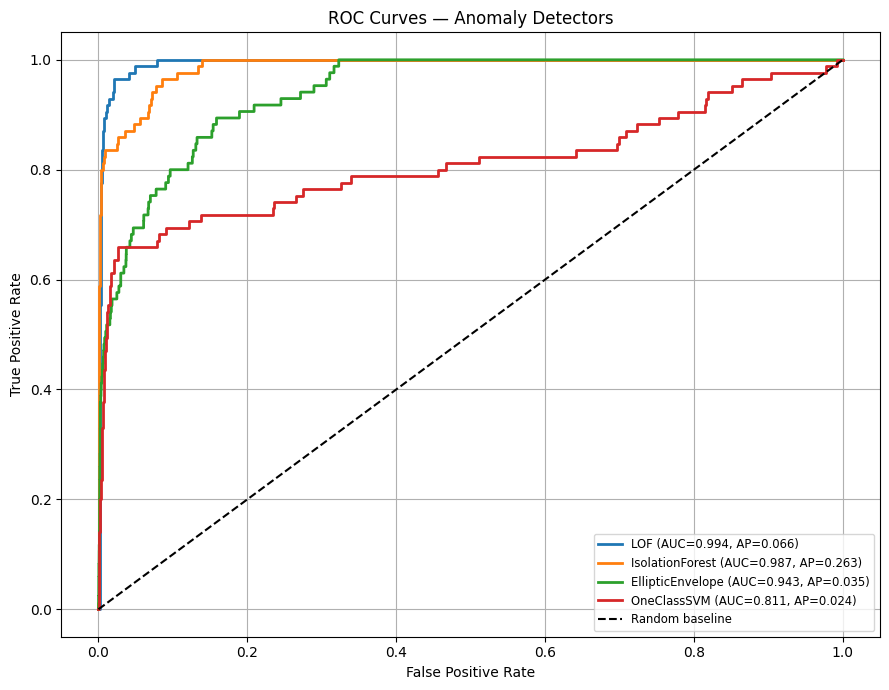

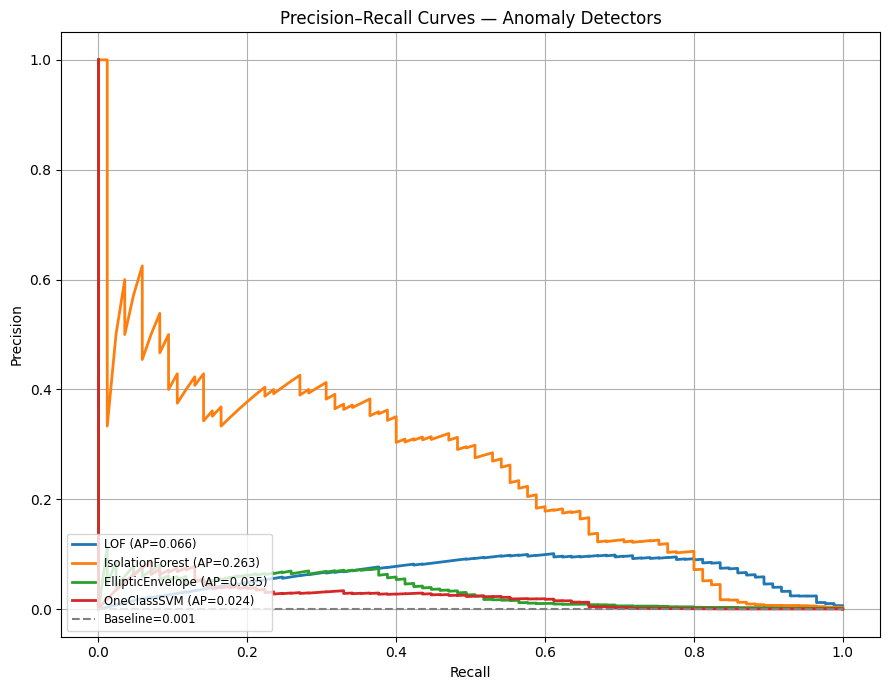

,name,dfvar,col,auc,ap,n
0,LOF,test_df1,anomaly_score_lof,0.994273,0.066096,160861
1,IsolationForest,test_df,anomaly_score,0.987148,0.262639,160861
2,EllipticEnvelope,test_df2,anomaly_score_elliptic,0.943247,0.034520,160861
3,OneClassSVM,test_df3,anomaly_score_ocsvm,0.810954,0.023855,160861


In [64]:
from sklearn.metrics import (
    roc_curve, roc_auc_score, average_precision_score,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from IPython.display import display
except ImportError:
    display = lambda df: print(df.to_string(index=False))

models_info = {
    'IsolationForest'   : ('test_df',  'anomaly_score'),
    'EllipticEnvelope'  : ('test_df2', 'anomaly_score_elliptic'),
    'OneClassSVM'       : ('test_df3', 'anomaly_score_ocsvm'),
    'LOF'       : ('test_df1', 'anomaly_score_lof'),
}

y_col = 'is_malicious'
results, skipped = [], []

for name, (dfvar, col) in models_info.items():
    df = globals().get(dfvar)
    if df is None or y_col not in df or col not in df:
        skipped.append((name, f"{dfvar} or column missing")); continue
    y, scores = df[y_col].astype(int).values, df[col].values
    mask = (~np.isnan(scores)) & (~np.isnan(y))
    if mask.sum()==0 or len(np.unique(y[mask]))<2 or np.all(scores[mask]==scores[mask][0]):
        skipped.append((name, "invalid data")); continue

    auc = roc_auc_score(y[mask], scores[mask])
    used = scores if auc>=0.5 else -scores
    if auc<0.5: auc = roc_auc_score(y[mask], used[mask])

    fpr, tpr, _ = roc_curve(y[mask], used[mask])
    ap = average_precision_score(y[mask], used[mask])

    results.append(dict(name=name, fpr=fpr, tpr=tpr, auc=auc, ap=ap,
                        dfvar=dfvar, col=col, n=int(mask.sum())))

if not results:
    print("Nothing to plot:", skipped)
else:
    results.sort(key=lambda r: r['auc'], reverse=True)

    plt.figure(figsize=(9,7))
    for r in results:
        ap_txt = f", AP={r['ap']:.3f}" if r['ap'] is not None else ""
        plt.plot(r['fpr'], r['tpr'], lw=2,
                 label=f"{r['name']} (AUC={r['auc']:.3f}{ap_txt})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random baseline")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves — Anomaly Detectors")
    plt.legend(loc='lower right', fontsize='small'); plt.grid(True); plt.tight_layout()
    plt.show()

    # Precision–Recall
    plt.figure(figsize=(9,7))
    for r in results:
        prec, rec, _ = precision_recall_curve(
            globals()[r['dfvar']][y_col].astype(int).values,
            globals()[r['dfvar']][r['col']].values if r['auc']>=0.5
            else -globals()[r['dfvar']][r['col']].values
        )
        plt.plot(rec, prec, lw=2, label=f"{r['name']} (AP={r['ap']:.3f})")
    base = (globals()['test_df'][y_col]==1).mean()
    plt.hlines(y=base, xmin=0, xmax=1,
           colors='gray', linestyles='--',
           label=f"Baseline={base:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves — Anomaly Detectors")
    plt.legend(loc='lower left', fontsize='small'); plt.grid(True); plt.tight_layout()
    plt.show()

    display(pd.DataFrame(results)[['name','dfvar','col','auc','ap','n']])

    if skipped:
        print("\nSkipped:", skipped)


In [65]:
from sklearn.metrics import (
    roc_curve, roc_auc_score, average_precision_score,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from IPython.display import display
except ImportError:
    display = lambda df: print(df.to_string(index=False))

models_info = {
    'IsolationForest'   : ('test_df',  'anomaly_score'),
    'EllipticEnvelope'  : ('test_df2', 'anomaly_score_elliptic'),
    'OneClassSVM'       : ('test_df3', 'anomaly_score_ocsvm'),
    'LOF'       : ('test_df1', 'anomaly_score_lof'),
}

y_col = 'is_malicious'
results, skipped = [], []

for name, (dfvar, col) in models_info.items():
    df = globals().get(dfvar)
    if df is None or not isinstance(df, pd.DataFrame) or y_col not in df or col not in df:
        skipped.append((name, f"{dfvar} or column missing"))
        continue

    y = df[y_col].astype(int).values
    scores = df[col].values
    mask = (~np.isnan(scores)) & (~np.isnan(y))

    # basic validation
    if mask.sum() == 0:
        skipped.append((name, "no valid (non-NaN) rows"))
        continue
    if len(np.unique(y[mask])) < 2:
        skipped.append((name, "only one class present in labelled data"))
        continue
    if np.all(scores[mask] == scores[mask][0]):
        skipped.append((name, "scores are constant"))
        continue

    # compute AUC and decide whether to flip sign (so higher => more likely positive)
    raw_auc = roc_auc_score(y[mask], scores[mask])
    if raw_auc < 0.5:
        used = -scores
        flipped = True
        auc = roc_auc_score(y[mask], used[mask])
    else:
        used = scores
        flipped = False
        auc = raw_auc

    fpr, tpr, _ = roc_curve(y[mask], used[mask])
    aucpr = average_precision_score(y[mask], used[mask])

    results.append(dict(
        name=name, fpr=fpr, tpr=tpr, auc=auc, aucpr=aucpr,
        dfvar=dfvar, col=col, n=int(mask.sum()), flipped=flipped
    ))

if not results:
    print("Nothing to plot. Skipped:", skipped)
else:
    # sort and plot ROC
    results.sort(key=lambda r: r['auc'], reverse=True)

    plt.figure(figsize=(9, 7))
    for r in results:
        aucpr_txt = f", AUCPR={r['aucpr']:.3f}" if r['aucpr'] is not None else ""
        plt.plot(r['fpr'], r['tpr'], lw=2,
                 label=f"{r['name']} (AUC={r['auc']:.3f}{aucpr_txt})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random baseline")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves — Anomaly Detectors")
    plt.legend(loc='lower right', fontsize='small'); plt.grid(True); plt.tight_layout()
    plt.savefig("roc_curves.png")
    plt.close()

    # Precision–Recall
    plt.figure(figsize=(9, 7))
    for r in results:
        df = globals()[r['dfvar']]
        scores = df[r['col']].values
        y = df[y_col].astype(int).values
        mask = (~np.isnan(scores)) & (~np.isnan(y))
        used = -scores if r.get('flipped', False) else scores
        prec, rec, _ = precision_recall_curve(y[mask], used[mask])
        plt.plot(rec, prec, lw=2, label=f"{r['name']} (AUCPR={r['aucpr']:.3f})")

    # baseline: try test_df first, otherwise average positive rate across provided dfs
    try:
        base = (globals()['test_df'][y_col] == 1).mean()
    except Exception:
        base_vals = []
        for r in results:
            df = globals()[r['dfvar']]
            if y_col in df:
                base_vals.append((df[y_col] == 1).mean())
        base = float(np.mean(base_vals)) if base_vals else 0.0

    plt.hlines(y=base, xmin=0, xmax=1,
               colors='gray', linestyles='--',
               label=f"Baseline={base:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves — Anomaly Detectors")
    plt.legend(loc='lower left', fontsize='small'); plt.grid(True); plt.tight_layout()
    plt.close()

    # show results table (rounded for readability)
    df_res = pd.DataFrame(results)[['name', 'dfvar', 'col', 'auc', 'aucpr', 'n']]
    df_res[['auc', 'aucpr']] = df_res[['auc', 'aucpr']].round(4)
    display(df_res)

    if skipped:
        print("\nSkipped:", skipped)


,name,dfvar,col,auc,aucpr,n
0,LOF,test_df1,anomaly_score_lof,0.9943,0.0661,160861
1,IsolationForest,test_df,anomaly_score,0.9871,0.2626,160861
2,EllipticEnvelope,test_df2,anomaly_score_elliptic,0.9432,0.0345,160861
3,OneClassSVM,test_df3,anomaly_score_ocsvm,0.8110,0.0239,160861


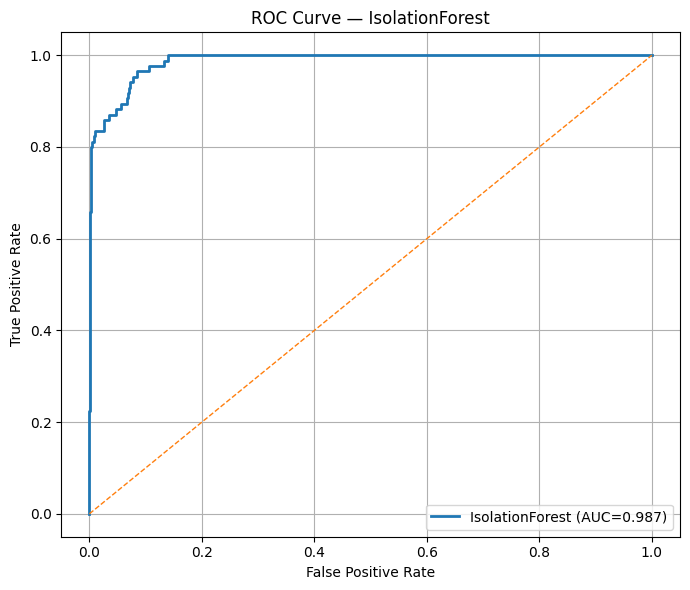

IsolationForest AUC: 0.9871


In [66]:
# ROC for IsolationForest only
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_col = 'is_malicious'
score_col = 'anomaly_score'  # IsolationForest score column in your notebook

if y_col not in test_df.columns:
    raise ValueError(f"Expected `{y_col}` column in test_df but not found.")
if score_col not in test_df.columns:
    raise ValueError(f"Expected `{score_col}` column in test_df but not found. Run the IF block that sets test_df['{score_col}'].")

y = test_df[y_col].astype(int).values
scores = test_df[score_col].values

# mask NaNs (if any)
mask = (~np.isnan(scores)) & (~np.isnan(y))
if mask.sum() == 0:
    raise ValueError("No valid score/label pairs available after removing NaNs.")

unique_classes = np.unique(y[mask])
if len(unique_classes) < 2:
    print("Cannot compute ROC/AUC: test set does not contain both classes. Found classes:", unique_classes)
else:
    auc = roc_auc_score(y[mask], scores[mask])
    fpr, tpr, _ = roc_curve(y[mask], scores[mask])

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'IsolationForest (AUC={auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve — IsolationForest')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # optionally save: plt.savefig('roc_isolation_forest.png', dpi=150)
    plt.show()

    print(f"IsolationForest AUC: {auc:.4f}")


In [67]:
# ----------------- thresholds: global and per-user -----------------
global_threshold = np.percentile(train_scores, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = train_ben_df.groupby('user')['anomaly_score'].quantile(pupct)
    # fallback for users not present in train benign -> use global
    test_df['anomaly_threshold'] = test_df['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df['anomaly_threshold'] = global_threshold

# mark model-detected anomalies (anomaly-only detection)
test_df['is_model_anomaly'] = (test_df['anomaly_score'] >= test_df['anomaly_threshold']).astype(int)

In [68]:
print(test_df['anomaly_threshold'].min())
print(test_df['anomaly_threshold'].max())

-0.1438268555985039
0.16952207322687443


In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ensure labels/preds exist
if 'is_model_anomaly' not in test_df.columns:
    raise RuntimeError("Column 'is_model_anomaly' not found in test_df")

y_true = test_df['is_malicious'].astype(int).values
y_pred = test_df['is_model_anomaly'].astype(int).values

if len(y_true) == 0:
    print("No rows in test set to evaluate.")
else:
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)  # rows: true, cols: pred

    print("Percentile: ", PCT_THRESHOLD)
    print("=== IF Detection metrics (anomaly-only thresholding) ===")
    print(f"Count (test rows) : {len(y_true)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")

    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))


Percentile:  99
=== IF Detection metrics (anomaly-only thresholding) ===
Count (test rows) : 160861
Accuracy : 0.9877
Precision: 0.0382
Recall   : 0.9176
F1 score : 0.0733

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[158812   1964]
 [     7     78]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    160776
           1       0.04      0.92      0.07        85

    accuracy                           0.99    160861
   macro avg       0.52      0.95      0.53    160861
weighted avg       1.00      0.99      0.99    160861



In [70]:
# ----------------- Investigation budgets for model-score re-rank -----------------
import numpy as np

# sanity checks
if 'test_df' not in globals():
    raise RuntimeError("test_df not found. Run previous blocks first.")
if 'is_model_anomaly' not in test_df.columns:
    raise RuntimeError("'is_model_anomaly' missing in test_df. Run detection thresholding first.")
if 'anomaly_score' not in test_df.columns:
    raise RuntimeError("'anomaly_score' missing in test_df. Run IF scoring first.")

# prepare ranked list of model-detected anomalies by model score (descending)
model_anoms = test_df[test_df['is_model_anomaly'] == 1].copy()
model_anoms = model_anoms.sort_values('anomaly_score', ascending=False).reset_index(drop=True)

# prepare matching keys for mapping back to full test (robust matching)
test_keys = list(zip(test_df['user'], pd.to_datetime(test_df['day'])))
model_keys = list(zip(model_anoms['user'], pd.to_datetime(model_anoms['day'])))

total_tp = int(test_df['is_malicious'].sum())
total_model_alerts = len(model_anoms)

print(f"\nTotal true positives in test set: {total_tp}")
print(f"Total model-detected anomalies: {total_model_alerts}\n")

if total_model_alerts == 0:
    print("No model-detected anomalies to evaluate.")
else:

    # Relative budgets (Top X% of the model-detected alerts)
    percent_budgets = [0.01, 0.02, 0.05, 0.10]  # 0.5%,1%,2%,5%,10%
    print("\nModel-score re-rank (Top X%):")
    print(f"{'Top-%':>8} | {'Top-N':>6} | {'% TP in budget':>15} | {'% of all TP covered':>21} | {'TP_in_budget':>12}")
    print("-"*88)
    for p in percent_budgets:
        k = max(1, int(np.floor(p * total_model_alerts)))
        head_keys = set(model_keys[:k])
        in_topk = np.array([1 if key in head_keys else 0 for key in test_keys], dtype=int)
        n_alerts = int(in_topk.sum())
        tp_in_budget = int(((test_df['is_malicious'].astype(int).values) * in_topk).sum())
        precision_pct = (tp_in_budget / n_alerts * 100.0) if n_alerts > 0 else 0.0
        coverage_pct = (tp_in_budget / total_tp * 100.0) if total_tp > 0 else float('nan')
        print(f"{p*100:7.2f}% | {k:6d} | {precision_pct:15.2f} | {coverage_pct:21.2f} | {tp_in_budget:12d}")

print("\nNote: '% TP in budget' = precision within that budget;")
print("      '% of all TP covered' = fraction of total test-set positives found inside the budget.\n")



Total true positives in test set: 85
Total model-detected anomalies: 2042


Model-score re-rank (Top X%):
   Top-% |  Top-N |  % TP in budget |   % of all TP covered | TP_in_budget
----------------------------------------------------------------------------------------
   1.00% |     20 |           40.00 |                  9.41 |            8
   2.00% |     40 |           35.00 |                 16.47 |           14
   5.00% |    102 |           33.33 |                 40.00 |           34
  10.00% |    204 |           24.02 |                 57.65 |           49

Note: '% TP in budget' = precision within that budget;
      '% of all TP covered' = fraction of total test-set positives found inside the budget.



In [71]:
 #----------------- Rule scoring function (deterministic) -----------------
def compute_rule_score_row(row):
    score = 0.0
    if row.get("wikileaks_flag",0) == 1:
        score += RULE_WEIGHTS["wikileaks_flag"]
    trio = {"offhour_usb_flag": row.get("offhour_usb_flag",0),
            "offhour_http_flag": row.get("offhour_http_flag",0),
            "offhour_logon_flag": row.get("offhour_logon_flag",0)}
    if trio["offhour_usb_flag"] == 1 or sum(trio.values()) >= 2:
        score += sum(RULE_WEIGHTS[k] for k,v in trio.items() if v==1)
    return score

# precompute rule_score on train/val/test (for tuning if needed)
train_ben_df['rule_score'] = train_ben_df.apply(compute_rule_score_row, axis=1)
test_df['rule_score'] = test_df.apply(compute_rule_score_row, axis=1)


In [72]:
# ----------------------------- rulescaling + hybrid (inserted block) -----------------------------
# w1 comes from the sidebar slider; w2 is complementary
w1 = 0.7
w2 = 1.0 - float(w1)

# --- 2. Normalize Scores to a [0, 1] Range ---
anomalies_all = test_df.loc[test_df['is_model_anomaly'] == 1].copy()

# Normalize rule_score using its theoretical maximum
max_possible_rule = sum(w for w in RULE_WEIGHTS.values() if w > 0) or 1.0
anomalies_all['rule_norm'] = (anomalies_all['rule_score'] / max_possible_rule).clip(0, 1)
# mirror into rule_scaled for display compatibility
anomalies_all['rule_scaled'] = anomalies_all['rule_norm']

# This correctly avoids data leakage.
score_min, score_max = train_scores.min(), train_scores.max()
anomalies_all['anomaly_norm'] = (anomalies_all['anomaly_score']-score_min)/(score_max-score_min)

# --- 3. Calculate the Hybrid Score ---
anomalies_all['hybrid_score'] = (w1 * anomalies_all['anomaly_norm']) + (w2 * anomalies_all['rule_norm'])

# --- 4. Rank by the new hybrid score ---
anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

In [73]:
import numpy as np

# anomalies_all must be the re-ranked DataFrame (descending hybrid_score)
# test_df must contain 'is_malicious' for total TPs

# safety checks
if 'anomalies_all' not in globals():
    raise RuntimeError("anomalies_all not found. Run the re-ranking block first.")
if 'test_df' not in globals():
    raise RuntimeError("test_df not found.")

total_tp = int(test_df['is_malicious'].sum())
total_alerts = len(anomalies_all)

print(f"Total re-ranked model-detected anomalies: {total_alerts}")
print(f"Total true positives in test set: {total_tp}\n")

if total_alerts == 0:
    print("No model-detected anomalies to evaluate.")
else:

    # define relative budgets (percent of re-ranked alerts)
    percent_budgets = [0.01, 0.02, 0.05, 0.10]  # 0.5%, 1%, 2%, 5%, 10%
    percent_budgets = [p for p in percent_budgets if p > 0]
    percent_budgets = sorted(list(set(percent_budgets)))

    print("\nRelative budgets (Top X% of re-ranked alerts):")
    print(f"{'Top-%':>8} | {'Top-N':>6} | {'TP in budget (%)':>17} | {'TPs in budget / All TPs (%)':>28} | {'#TP_in_budget':>14}")
    print("-"*100)
    for p in percent_budgets:
        k = max(1, int(np.floor(p * total_alerts)))
        head = anomalies_all.head(k)
        n_alerts = len(head)
        tp_in_budget = int(head['is_malicious'].sum())
        precision_pct = (tp_in_budget / n_alerts * 100.0) if n_alerts>0 else 0.0
        coverage_pct = (tp_in_budget / total_tp * 100.0) if total_tp>0 else float('nan')
        print(f"{p*100:7.2f}% | {k:6d} | {precision_pct:17.2f} | {coverage_pct:28.2f} | {tp_in_budget:14d}")


Total re-ranked model-detected anomalies: 2042
Total true positives in test set: 85


Relative budgets (Top X% of re-ranked alerts):
   Top-% |  Top-N |  TP in budget (%) |  TPs in budget / All TPs (%) |  #TP_in_budget
----------------------------------------------------------------------------------------------------
   1.00% |     20 |            100.00 |                        23.53 |             20
   2.00% |     40 |             95.00 |                        44.71 |             38
   5.00% |    102 |             65.69 |                        78.82 |             67
  10.00% |    204 |             33.82 |                        81.18 |             69


In [74]:
# determine which rule flags to inspect (fall back to names in environment)
rule_flags = RULE_FLAG_NAMES if 'RULE_FLAG_NAMES' in globals() else ['wikileaks_flag','offhour_usb_flag','offhour_http_flag','offhour_logon_flag']

def list_triggered_rules(row, flags=rule_flags):
    triggered = [f for f in flags if int(row.get(f, 0)) == 1]
    return ",".join(triggered) if triggered else "none"

# Add triggered_rules column (row-level)
anomalies_all1 = anomalies_all.sort_values('anomaly_score', ascending=False).reset_index(drop=True)
anomalies_all1['triggered_rules'] = anomalies_all1.apply(lambda r: list_triggered_rules(r), axis=1)

# Top 10 rows
top10_rows = anomalies_all1.head(10)[['user','day','anomaly_score','triggered_rules','is_malicious']].reset_index(drop=True)
print("Top 10 anomaly rows by anomaly_score (row-level):")
display(top10_rows)   # in Jupyter; use print(top10_rows.to_string(index=False)) if display not available

# Save to CSV if you want
#top10_rows.to_csv('/content/top10_hybrid_rows.csv', index=False)
#print("Saved /content/top10_hybrid_rows.csv")


Top 10 anomaly rows by anomaly_score (row-level):


,user,day,anomaly_score,triggered_rules,is_malicious
0,CAH0936,2010-08-11,0.234472,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
1,GKO0078,2011-03-22,0.230437,"offhour_logon_flag,offhour_usb_flag,offhour_ht...",0
2,BIH0745,2010-07-02,0.218159,"offhour_logon_flag,offhour_usb_flag,offhour_ht...",0
3,JRG0207,2011-01-20,0.213535,"offhour_logon_flag,offhour_usb_flag,offhour_ht...",1
4,EHD0584,2010-10-02,0.209300,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
5,FMG0527,2011-01-07,0.205517,"offhour_logon_flag,offhour_usb_flag,offhour_ht...",0
6,LJR0523,2010-07-31,0.205105,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
7,EHD0584,2010-10-07,0.205066,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
8,BVC0790,2010-12-17,0.202330,"offhour_logon_flag,offhour_usb_flag,offhour_ht...",0
9,DIW0118,2011-03-29,0.200771,"offhour_logon_flag,offhour_usb_flag,offhour_ht...",0


In [75]:
# determine which rule flags to inspect (fall back to names in environment)
rule_flags = RULE_FLAG_NAMES if 'RULE_FLAG_NAMES' in globals() else ['wikileaks_flag','offhour_usb_flag','offhour_http_flag','offhour_logon_flag']

def list_triggered_rules(row, flags=rule_flags):
    triggered = [f for f in flags if int(row.get(f, 0)) == 1]
    return ",".join(triggered) if triggered else "none"

# Add triggered_rules column (row-level)
anomalies_all['triggered_rules'] = anomalies_all.apply(lambda r: list_triggered_rules(r), axis=1)

# Top 10 rows
top10_rows = anomalies_all.head(10)[['user','day','hybrid_score','anomaly_score','anomaly_norm','rule_norm','rule_score','triggered_rules','is_malicious']].reset_index(drop=True)
print("Top 10 anomaly rows by hybrid_score (row-level):")
display(top10_rows)   # in Jupyter; use print(top10_rows.to_string(index=False)) if display not available

# Save to CSV if you want
top10_rows.to_csv('/content/top10_hybrid_rows.csv', index=False)
print("Saved /content/top10_hybrid_rows.csv")


Top 10 anomaly rows by hybrid_score (row-level):


,user,day,hybrid_score,anomaly_score,anomaly_norm,rule_norm,rule_score,triggered_rules,is_malicious
0,CAH0936,2010-08-11,1.014929,0.234472,1.021328,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
1,EHD0584,2010-10-02,0.972440,0.209300,0.960629,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
2,LJR0523,2010-07-31,0.965359,0.205105,0.950513,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
3,EHD0584,2010-10-07,0.965294,0.205066,0.950420,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
4,BTL0226,2010-10-06,0.956955,0.200126,0.938508,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
5,TAP0551,2010-10-29,0.956206,0.199682,0.937437,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
6,EHB0824,2010-07-28,0.945627,0.193414,0.922325,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
7,TAP0551,2010-10-23,0.935531,0.187433,0.907901,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
8,LQC0479,2010-09-15,0.928432,0.183227,0.897760,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
9,RGG0064,2010-10-20,0.927421,0.182628,0.896315,1.0,2.3,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1


Saved /content/top10_hybrid_rows.csv


In [76]:
# ---------------------------
# Show one malicious user whose rank improved after hybrid re-rank
# Paste this AFTER anomalies_all is available
# ---------------------------

import numpy as np

if 'anomalies_all' not in globals():
    # compute anomalies_all same as notebook fallback
    if 'test_df' not in globals():
        raise RuntimeError("test_df not found; run detection first.")

anoms = anomalies_all.copy()

# ranks within model-detected alerts (1 = highest anomaly_score)
anoms['model_rank']  = anoms['anomaly_score'].rank(method='min', ascending=False).astype(int)
anoms['hybrid_rank'] = anoms['hybrid_score'].rank(method='min', ascending=False).astype(int)
anoms['rank_change'] = anoms['model_rank'] - anoms['hybrid_rank']

# rule flags to inspect
rule_flags = RULE_FLAG_NAMES if 'RULE_FLAG_NAMES' in globals() else ['wikileaks_flag','offhour_usb_flag','offhour_http_flag','offhour_logon_flag']

def _triggered_list(row):
    trig = [f for f in rule_flags if int(row.get(f, 0)) == 1]
    return ",".join(trig) if trig else "none"

anoms['triggered_rules'] = anoms.apply(_triggered_list, axis=1)

# find one malicious row that improved (rank_change > 0)
cand = anoms[(anoms.get('is_malicious',0)==1) & (anoms['rank_change'] > 0)]

if cand.empty:
    print("No malicious model-detected alert improved its rank after hybrid re-rank.")
    # optional: show the top improved non-malicious if you want a concrete example
    top_nonmal = anoms[anoms['rank_change'] > 0].sort_values('rank_change', ascending=False)
    if len(top_nonmal) > 0:
        row = top_nonmal.iloc[0]
        print("\nShowing top-improved non-malicious example instead:")
        print(f"User: {row['user']}, day: {row.get('day')}")
        print(f"Anomaly score: {row['anomaly_score']:.6f}")
        print(f"Model rank -> Hybrid rank: {row['model_rank']} -> {row['hybrid_rank']} (change {int(row['rank_change'])})")
        print(f"Rule score: {row.get('rule_score', np.nan)}; Triggered rules: {row['triggered_rules']}")
    else:
        print("No rows moved up after hybrid re-rank at all.")
else:
    # pick the malicious user with largest improvement
    row = cand.sort_values('rank_change', ascending=False).iloc[0]
    print("Malicious user whose rank increased after hybrid re-rank (best improvement):")
    print(f"User: {row['user']}")
    print(f"Day: {row.get('day')}")
    print(f"Anomaly score: {row['anomaly_score']:.6f}")
    print(f"Rank in model-detected alerts (model_rank): {int(row['model_rank'])}")
    print(f"Rank after hybrid re-rank (hybrid_rank): {int(row['hybrid_rank'])}")
    print(f"Rank change (model_rank - hybrid_rank): {int(row['rank_change'])}  (positive => moved up)")
    print(f"Rule score: {row.get('rule_score', np.nan)}")
    print(f"Triggered rules that helped: {row['triggered_rules']}")


Malicious user whose rank increased after hybrid re-rank (best improvement):
User: EHB0824
Day: 2010-07-22 00:00:00
Anomaly score: 0.040049
Rank in model-detected alerts (model_rank): 711
Rank after hybrid re-rank (hybrid_rank): 138
Rank change (model_rank - hybrid_rank): 573  (positive => moved up)
Rule score: 2.3
Triggered rules that helped: wikileaks_flag,offhour_logon_flag,offhour_usb_flag,offhour_http_flag


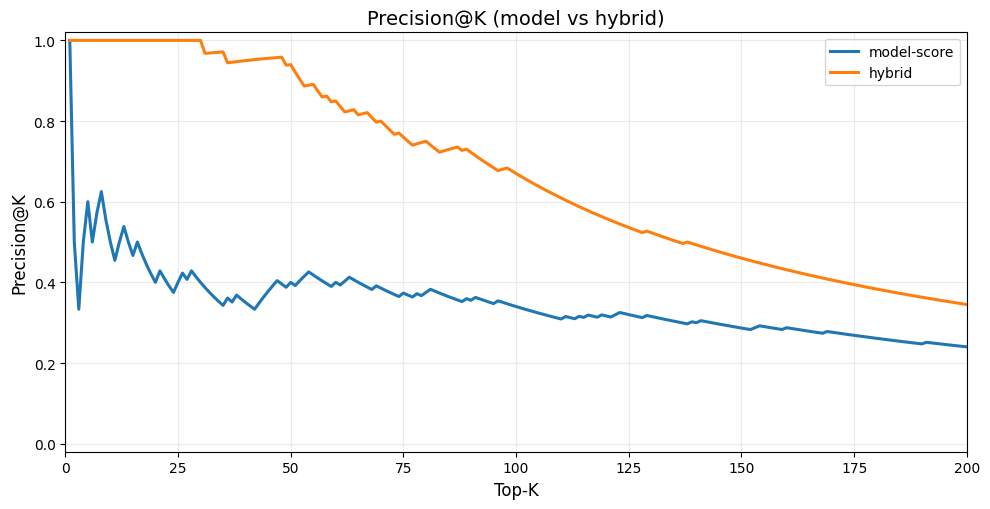

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# safety checks
for name in ['test_df', 'model_anoms', 'anomalies_all']:
    if name not in globals():
        raise RuntimeError(f"{name} not found. Please create it in the environment before running this cell.")

# copies & normalize day column if present
test_df = test_df.copy()
if 'day' in test_df.columns:
    test_df['day'] = pd.to_datetime(test_df['day'])

model_anoms = model_anoms.copy()
if 'day' in model_anoms.columns:
    model_anoms['day'] = pd.to_datetime(model_anoms['day'])

anomalies_all = anomalies_all.copy()
if 'day' in anomalies_all.columns:
    anomalies_all['day'] = pd.to_datetime(anomalies_all['day'])

def ensure_is_malicious(df, test_df):
    if 'is_malicious' not in df.columns:
        join_cols = ['user', 'day'] if 'day' in df.columns else ['user']
        df = df.merge(test_df[join_cols + ['is_malicious']], on=join_cols, how='left')
        df['is_malicious'] = df['is_malicious'].fillna(0).astype(int)
    else:
        df['is_malicious'] = df['is_malicious'].astype(int)
    return df

model_anoms = ensure_is_malicious(model_anoms, test_df)
anomalies_all = ensure_is_malicious(anomalies_all, test_df)

# ensure sorted descending by their respective scores if available
if 'anomaly_score' in model_anoms.columns:
    model_anoms = model_anoms.sort_values('anomaly_score', ascending=False).reset_index(drop=True)
if 'hybrid_score' in anomalies_all.columns:
    anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

# compute cumulative TPs arrays
cum_tp_model = model_anoms['is_malicious'].astype(int).cumsum().to_numpy()
cum_tp_hybrid = anomalies_all['is_malicious'].astype(int).cumsum().to_numpy()

len_model = len(model_anoms)
len_hybrid = len(anomalies_all)

MAX_K = 200
ks = np.arange(1, MAX_K+1)

# For k > length of list, assume missing alerts are non-alerts (i.e., zeros);
# precision = cum_tp_total / k.
prec_model = np.array([ (cum_tp_model[k-1] / k) if k <= len_model else (cum_tp_model[-1] / k if len_model>0 else 0.0)
                        for k in ks ])
prec_hybrid = np.array([ (cum_tp_hybrid[k-1] / k) if k <= len_hybrid else (cum_tp_hybrid[-1] / k if len_hybrid>0 else 0.0)
                         for k in ks ])

# Create plot with the requested look
plt.figure(figsize=(10,5.2))
plt.plot(ks, prec_model, linewidth=2.2, label='model-score')
plt.plot(ks, prec_hybrid, linewidth=2.2, label='hybrid')

plt.xlabel('Top-K', fontsize=12)
plt.ylabel('Precision@K', fontsize=12)
plt.title('Precision@K (model vs hybrid)', fontsize=14)
plt.xlim(0, MAX_K)
plt.ylim(-0.02, 1.02)
plt.grid(alpha=0.25)
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

In [78]:
# --- Fixed version that handles dtype conversion ---

from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, recall_score, precision_score,
    roc_auc_score, average_precision_score
)

from sklearn.ensemble import IsolationForest
RANDOM_STATE = 42
PCT_THRESHOLD = 99

train_pu = X_train_if
test_pu  = X_test

# Attach user back to feature frames for per-user thresholding
train_g_with_user = pd.concat(
    [train_g1[['user']].reset_index(drop=True), train_g.reset_index(drop=True)],
    axis=1
)
test_g_with_user = pd.concat(
    [test_g1[['user']].reset_index(drop=True), test_g.reset_index(drop=True)],
    axis=1
)

train_pu_with_user = pd.concat(
    [train_df[['user']].reset_index(drop=True), X_train_if.reset_index(drop=True)],
    axis=1
)
test_pu_with_user = pd.concat(
    [test_df[['user']].reset_index(drop=True), X_test.reset_index(drop=True)],
    axis=1
)


# --- Isolation Forest helper functions ---
def fit_if_and_score(train_df_norm, test_df_norm, random_state=RANDOM_STATE):
    # Exclude identifier columns if present
    feature_cols = [c for c in train_df_norm.columns if c != 'user']

    if_model = IsolationForest(
        n_estimators=500,
        contamination='auto',
        max_features=0.5,
        random_state=42,
        n_jobs=-1
    )

    X_train = train_df_norm[feature_cols].values
    if_model.fit(X_train)

    def anomaly_scores(df):
        return (-if_model.score_samples(df[feature_cols].values)).astype(float)

    train_scores = anomaly_scores(train_df_norm)
    test_scores  = anomaly_scores(test_df_norm)

    return if_model, train_scores, test_scores


def global_threshold_from_benign(train_scores, percentile=PCT_THRESHOLD):
    return float(np.percentile(train_scores, percentile))

def per_user_thresholds_from_benign(train_df_norm, percentile=PCT_THRESHOLD, random_state=RANDOM_STATE):
    # Ensure 'user' exists for grouping; if not, raise a clear error
    if 'user' not in train_df_norm.columns:
        raise ValueError("train_df_norm must include a 'user' column for per-user thresholds")

    # Separate features from grouping column
    feature_cols = [c for c in train_df_norm.columns if c != 'user']

    # Fit IF on features only
    if_model = IsolationForest(
        n_estimators=500,
        contamination='auto',
        max_features=0.5,
        random_state=random_state,
        n_jobs=-1
    )
    X_train = train_df_norm[feature_cols].values
    if_model.fit(X_train)

    # Score all training rows (assumed benign set); no DataFrame-as-indexer
    scores_all = (-if_model.score_samples(train_df_norm[feature_cols].values)).astype(float)

    # Build per-user thresholds at the given percentile
    tmp = train_df_norm[['user']].copy()
    tmp['user'] = tmp['user'].astype(str)  # stable key dtype
    tmp['score'] = scores_all
    thr = tmp.groupby('user')['score'].quantile(percentile / 100.0).to_dict()
    return thr


def predict_with_threshold_global(scores_vec, thr):
    return (scores_vec >= thr).astype(int)

def predict_with_threshold_per_user(df_with_scores, user_thresholds, global_thr_fallback):
    preds = np.zeros(len(df_with_scores), dtype=int)
    users = df_with_scores['user'].astype(str).values  # ensure same dtype as thresholds dict keys
    scores = df_with_scores['score'].values
    for i in range(len(df_with_scores)):
        t = user_thresholds.get(users[i], global_thr_fallback)
        preds[i] = 1 if scores[i] >= t else 0
    return preds


def evaluate_all(y_true, y_pred, y_score):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_score),
        'ap': average_precision_score(y_true, y_score),
    }

# --- Run all 4 scenarios ---
print("Running Isolation Forest evaluation across 4 scenarios...")


# Scenario 1: Global normalization + Global threshold
_, tr_scores_g, te_scores_g = fit_if_and_score(train_g, test_g, random_state=RANDOM_STATE)
thr_g = global_threshold_from_benign(tr_scores_g, percentile=PCT_THRESHOLD)
pred_s1 = predict_with_threshold_global(te_scores_g, thr_g)
res_s1 = evaluate_all(test_g1['is_malicious'].values, pred_s1, te_scores_g)

# Scenario 2: Global normalization + Per-user threshold
user_thrs_g = per_user_thresholds_from_benign(train_g_with_user, percentile=PCT_THRESHOLD, random_state=RANDOM_STATE)
te_df_g_scores = test_g_with_user[['user']].copy()
te_df_g_scores['score'] = te_scores_g
pred_s2 = predict_with_threshold_per_user(te_df_g_scores, user_thrs_g, thr_g)
res_s2 = evaluate_all(test_g1['is_malicious'].values, pred_s2, te_scores_g)

# Scenario 3: Per-user normalization + Global threshold
_, tr_scores_pu, te_scores_pu = fit_if_and_score(train_pu, test_pu, random_state=RANDOM_STATE)
thr_pu = global_threshold_from_benign(tr_scores_pu, percentile=PCT_THRESHOLD)
pred_s3 = predict_with_threshold_global(te_scores_pu, thr_pu)
res_s3 = evaluate_all(test_df['is_malicious'].values, pred_s3, te_scores_pu)

# Scenario 4: Per-user normalization + Per-user threshold
user_thrs_pu = per_user_thresholds_from_benign(train_pu_with_user, percentile=PCT_THRESHOLD, random_state=RANDOM_STATE)
te_df_pu_scores = test_pu_with_user[['user']].copy()
te_df_pu_scores['score'] = te_scores_pu
pred_s4 = predict_with_threshold_per_user(te_df_pu_scores, user_thrs_pu, thr_pu)
res_s4 = evaluate_all(test_df['is_malicious'].values, pred_s4, te_scores_pu)

# --- Results display ---
def print_results(tag, res):
    print(f"{tag}:")
    print(f"  Accuracy={res['accuracy']:.4f} | Precision={res['precision']:.4f} | Recall={res['recall']:.4f}")
    print(f"  F1={res['f1']:.4f} | AUC={res['auc']:.4f} | AP={res['ap']:.4f}")
    print(f"  Confusion Matrix: TN={res['tn']}, FP={res['fp']}, FN={res['fn']}, TP={res['tp']}")
    print()

print("="*80)
print("ISOLATION FOREST EVALUATION RESULTS - ALL 4 SCENARIOS")
print("="*80)

print_results("S1: Global Normalization + Global Threshold", res_s1)
print_results("S2: Global Normalization + Per-User Threshold", res_s2)
print_results("S3: Per-User Normalization + Global Threshold", res_s3)
print_results("S4: Per-User Normalization + Per-User Threshold", res_s4)

# Create comparison DataFrame
eval_df = pd.DataFrame([
    {'scenario': 'GlobalNorm+GlobalThr',   **res_s1},
    {'scenario': 'GlobalNorm+PerUserThr',  **res_s2},
    {'scenario': 'PerUserNorm+GlobalThr',  **res_s3},
    {'scenario': 'PerUserNorm+PerUserThr', **res_s4},
])

print("="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(eval_df[['scenario', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'ap']])

# Optional: Save to CSV
# eval_df.to_csv('isolation_forest_four_scenarios_results.csv', index=False)


Running Isolation Forest evaluation across 4 scenarios...
ISOLATION FOREST EVALUATION RESULTS - ALL 4 SCENARIOS
S1: Global Normalization + Global Threshold:
  Accuracy=0.9893 | Precision=0.0136 | Recall=0.2706
  F1=0.0259 | AUC=0.9470 | AP=0.0146
  Confusion Matrix: TN=159110, FP=1666, FN=62, TP=23

S2: Global Normalization + Per-User Threshold:
  Accuracy=0.9890 | Precision=0.0389 | Recall=0.8353
  F1=0.0743 | AUC=0.9470 | AP=0.0146
  Confusion Matrix: TN=159020, FP=1756, FN=14, TP=71

S3: Per-User Normalization + Global Threshold:
  Accuracy=0.9905 | Precision=0.0449 | Recall=0.8353
  F1=0.0852 | AUC=0.9871 | AP=0.2626
  Confusion Matrix: TN=159265, FP=1511, FN=14, TP=71

S4: Per-User Normalization + Per-User Threshold:
  Accuracy=0.9877 | Precision=0.0382 | Recall=0.9176
  F1=0.0733 | AUC=0.9871 | AP=0.2626
  Confusion Matrix: TN=158812, FP=1964, FN=7, TP=78

SUMMARY COMPARISON TABLE
                 scenario  accuracy  precision    recall        f1       auc  \
0    GlobalNorm+Glob